# ResNet

In [3]:
#Load necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Load CIFAR Dataset

To obtain the CIFAR10 dataset, go here: https://www.cs.toronto.edu/~kriz/cifar.html

The training data is stored in 5 separate files, and we will alternate between them during training.

In [4]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def ConvertImages(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, 3, 32, 32])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images

In [5]:
currentCifar = 1
cifar = unpickle('./cifar10/data_batch_1')
cifarT = unpickle('./cifar10/test_batch')

In [6]:
total_layers = 25 #Specify how deep we want our network
units_between_stride = total_layers / 5

## ResNet
An implementation of a Residual Network as described in [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027).

In [7]:
def resUnit(input_layer,i):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = slim.batch_norm(input_layer,activation_fn=None)
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,64,[3,3],activation_fn=None)
        part4 = slim.batch_norm(part3,activation_fn=None)
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,64,[3,3],activation_fn=None)
        output = input_layer + part6
        return output

tf.reset_default_graph()

input_layer = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32,name='input')
label_layer = tf.placeholder(shape=[None],dtype=tf.int32)
label_oh = slim.layers.one_hot_encoding(label_layer,10)

layer1 = slim.conv2d(input_layer,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
for i in range(5):
    for j in range(units_between_stride):
        layer1 = resUnit(layer1,j + (i*units_between_stride))
    layer1 = slim.conv2d(layer1,64,[3,3],stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))
    
top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')

output = slim.layers.softmax(slim.layers.flatten(top))

loss = tf.reduce_mean(-tf.reduce_sum(label_oh * tf.log(output) + 1e-10, axis=[1]))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
update = trainer.minimize(loss)

### Visualize the network graph
We can call the Tensorflow Board to provide a graphical representation of our network.

In [8]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [9]:
show_graph(tf.get_default_graph().as_graph_def())

## Training

In [8]:
init = tf.global_variables_initializer()
batch_size = 64
currentCifar = 1
total_steps = 20000
l = []
a = []
aT = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)
i = 0
draw = range(10000)
while i < total_steps:
    if i % (10000/batch_size) != 0:
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    else:
        draw = range(10000)
        if currentCifar == 5:
            currentCifar = 1
            print "Switched CIFAR set to " + str(currentCifar)
        else:
            currentCifar = currentCifar + 1
            print "Switched CIFAR set to " + str(currentCifar)
        cifar = unpickle('./cifar10/data_batch_'+str(currentCifar))
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    x = ConvertImages(cifar['data'][batch_index])  
    y = np.reshape(np.array(cifar['labels'])[batch_index],[batch_size,1])
    _,lossA,yP,LO = sess.run([update,loss,output,label_oh],feed_dict={input_layer:x,label_layer:np.hstack(y)})
    accuracy = np.sum(np.equal(np.hstack(y),np.argmax(yP,1)))/float(len(y))
    l.append(lossA)
    a.append(accuracy)
    if i % 10 == 0: print "Step: " + str(i) + " Loss: " + str(lossA) + " Accuracy: " + str(accuracy)
    if i % 100 == 0: 
        point = np.random.randint(0,10000-500)
        xT = ConvertImages(cifarT['data'][point:point+500]) 
        yT = np.reshape(np.array(cifarT['labels'])[point:point+500],[500])
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:xT,label_layer:yT})
        accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
        aT.append(accuracy)
        print "Test set accuracy: " + str(accuracy)
    i+= 1
save_path = saver.save(sess, "./trainingmodels/ResNet/model_resnet.ckpt")
print "Model saved in file: " + str(save_path)
sess.close()

Switched CIFAR set to 2
Step: 0 Loss: 2.73913 Accuracy: 0.0625
Test set accuracy: 0.088
Step: 10 Loss: 2.24243 Accuracy: 0.125
Step: 20 Loss: 2.13813 Accuracy: 0.21875
Step: 30 Loss: 1.99451 Accuracy: 0.25
Step: 40 Loss: 1.95367 Accuracy: 0.34375
Step: 50 Loss: 1.94094 Accuracy: 0.265625
Step: 60 Loss: 1.84243 Accuracy: 0.3125
Step: 70 Loss: 1.76406 Accuracy: 0.34375
Step: 80 Loss: 1.8379 Accuracy: 0.328125
Step: 90 Loss: 1.68521 Accuracy: 0.40625
Step: 100 Loss: 1.663 Accuracy: 0.421875
Test set accuracy: 0.386
Step: 110 Loss: 1.80161 Accuracy: 0.390625
Step: 120 Loss: 1.85125 Accuracy: 0.359375
Step: 130 Loss: 1.57063 Accuracy: 0.40625
Step: 140 Loss: 1.98401 Accuracy: 0.203125
Step: 150 Loss: 1.65642 Accuracy: 0.375
Switched CIFAR set to 3
Step: 160 Loss: 1.73245 Accuracy: 0.265625
Step: 170 Loss: 1.56421 Accuracy: 0.421875
Step: 180 Loss: 1.74444 Accuracy: 0.34375
Step: 190 Loss: 1.50416 Accuracy: 0.4375
Step: 200 Loss: 1.63111 Accuracy: 0.40625
Test set accuracy: 0.454
Step: 210 L

## Results

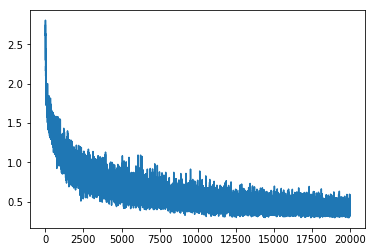

In [9]:
plt.plot(l) #Plot training loss

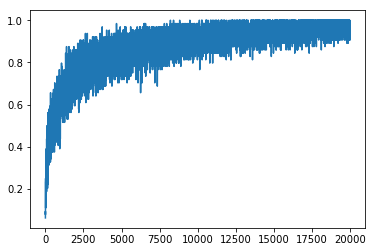

In [10]:
plt.plot(a) #Plot training accuracy

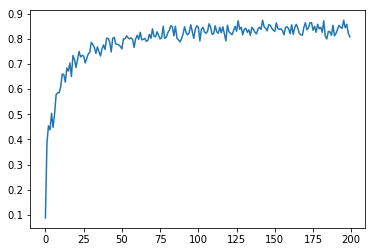

In [11]:
plt.plot(aT) #Plot test accuracy

In [12]:
np.max(aT) #Best test accuracy

0.874

In [1]:
# Calculate test accuracy
def CalcTestAccuracy(sess, data, labels, isTransformed):
    
    percentageList = np.zeros(10)
    
    yT = np.reshape(np.array(labels),[len(labels)])
    if(isTransformed):
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:data.eval(),label_layer:yT})
    else:
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:data,label_layer:yT})
    
    equal = np.equal(yT,np.argmax(yP,1))
    accuracy = np.sum(equal)/float(len(yT))
    print "Test set accuracy: " + str(accuracy)
    
    for i in range(0,len(yT)):
        if equal[i] == False:
            index = yT[i]
            percentageList[index] += 1
    
    return accuracy, percentageList


In [ ]:
def RotateAndCalc(sess, images, labels):
    #List with all accuracies
    accList = []
    prcList = np.zeros(len(labels))
    
    rotAngle = 10
    curAngle = 10

    #First run for original image
    fAcc,fPrc = CalcTestAccuracy(sess, ConvertImages(images), labels, False)
    accList.append(fAcc)
    prcList = [x+y for x, y in zip(prcList, fPrc)]

    #Rotate 10 degree
    while curAngle < 360:
        print "Rotating degree " + str(curAngle)
        rotImages = tf.contrib.image.rotate(ConvertImages(images), np.radians(curAngle))

        #Calc accuracy for the rotated images
        sAcc, sPrc = CalcTestAccuracy(sess, rotImages, labels, True)
        prcList = [x+y for x, y in zip(prcList, sPrc)]
        accList.append(sAcc)

        #Increment or curAngle with +rotAngle
        curAngle += rotAngle
       
    #Get failures in percentage
    prcSum = sum(prcList)
    nPrcList = []
    for numb in prcList:
        nPrcList.append((numb / prcSum) * 100)
    
    return accList, nPrcList

def GetLabelData(numbOfImg):
    images = []
    labels = []
    currImg = 0
    index = 0
        
    #Collect data for one specific label
    while currImg < numbOfImg:
        if cifarT['labels'][index] == label:
            images.append(cifarT['data'][index])
            labels.append(cifarT['labels'][index])
            currImg += 1
        index += 1
    return images, labels

def GetScrambleData(numbOfImg):
    #Collect data across labels
    images = cifarT['data'][0:numbOfImg]
    labels = cifarT['labels'][0:numbOfImg]
    return images, labels

def PlotAcc(accList):
    #Plot our accuracies
    x = np.arange(0, 360, 10)
    plt.xlabel('Degree')
    plt.ylabel('Accuracy')
    plt.title('Accuracy with rotating images')
    plt.plot(x,accList)
    plt.show()
    

np.seterr(divide='ignore', invalid='ignore')
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./trainingmodels/ResNet/model_resnet.ckpt")
    print "Model restored."
    
    numbOfImg = 1000 #Number of images to be found
    finalLabelList = [] #List with each labellist inside it
    
    #Scramble classification
    print "Scramble classification"
    sImages, sLabels = GetScrambleData(1000)
    sAcc, sPrc = RotateAndCalc(sess, sImages, sLabels)
    print "Percentage for failing classification: "
    print sPrc
    print "Total accuracy for the test set: " + str(sAcc[0])
    PlotAcc(sAcc)
    
    #Label wise classification
    print "Label wise classification"
    for label in range(0,10): #Label value 0-9
        print "Classifying on label: " + str(label)
        images, labels = GetLabelData(numbOfImg)
        lAcc,_ = RotateAndCalc(sess, images, labels)
        finalLabelList.append(lAcc)
        PlotAcc(lAcc)
        
        
    # Print all the label wise in same plot
    Labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    for i in range(len(finalLabelList)):
        x = np.arange(0, 360, 10)
        plt.xlabel('Degree')
        plt.ylabel('Accuracy')
        plt.title('Accuracy with rotating images')
        plt.plot(x,finalLabelList[i], label=Labels[i])

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show() 
        